# House Price Prediction Model

Given is a dataset pertaining to the sale information of houses in different cities.
All the analysis here will lead us to a predictive model of sale prices. First we'll get to know the data in hand with Exploratory data analysis along with dimentionality reduction.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')


#training data treatment
print(df.info())

#Removing columns having more than 30% null values
mask_null = df.isnull().sum() / len(df) < 0.3
df = df.loc[: , mask_null]

#Information of all non-numric data
#converting some columns to their true data type for better data handling
#columns belong to 'category' dtype
for i  in ['MSSubClass', 'OverallQual', 'OverallCond']:
    df[i] = df[i].astype('category')

#columns belong to 'datetime'
for i in ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt', 'MoSold']:
    if i == 'MoSold':
        df[i] = pd.to_datetime(df[i], format= '%m')
    else :
        df[i] = pd.to_datetime(df[i])

#Columns with the frequency of top category
print('\n', df.describe(exclude= 'number').loc['freq', :].sort_values())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Categorical features which does not show any variability acorss the data does not provide any useful information for our future analysis. For e.g:

In the column 'Street' 1454 entries are 'Pave' out of 1460. This makes a bad candidate for predicting Sale price. We can further get confidence about removing this feature by visualizing it with the target variable to account for any peculiar behaviour.
Other such columns are: Utilities, Condition2 , RoofMatl, Heating

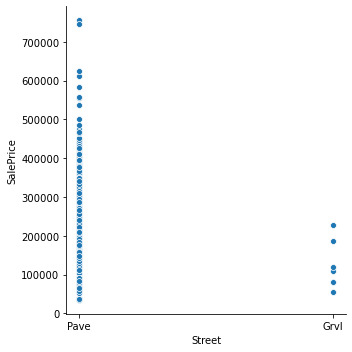

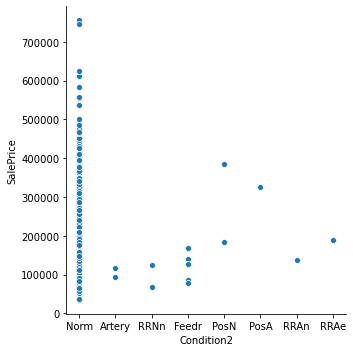

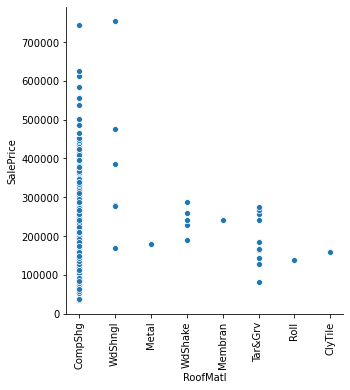

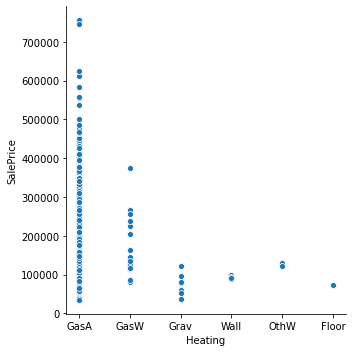

In [2]:
sns.relplot(x= 'Street', y= 'SalePrice', data= df, palette= 'husl')
sns.relplot(x= 'Condition2', y= 'SalePrice', data= df, palette= 'husl')
sns.relplot(x= 'RoofMatl', y= 'SalePrice', data= df, palette= 'husl')
plt.xticks(rotation= 90)
sns.relplot(x= 'Heating', y= 'SalePrice', data= df, palette= 'husl')

In these features a single category dominates and hence does not provide much informatio for the model.
I'll also remove all the year columns because they dont provide any information for classification as each one of them has only one value, 1970.

In [3]:
#Drop categorical features with less information
df.drop(['Utilities', 'Street', 'Condition2', 'RoofMatl', 'Heating', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt', 'MoSold'], axis= 1, inplace= True)

Now let's focus on numeric features. We can apply a same approach with numeric data as we did with the non-numeric one. Features with very less **variance** do not provide much information.
But now instead of doing it manually we'll automate the process using regressors provided by sklearn which themselves does the feature selection for us. For this purpose we'll use three models : linear regressor (lasso), Random forest and gradient boosting .

In [4]:
#import required functions
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#for recursice feature selection
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

#Get numeric features
df_num = df[df.describe().columns]

#drop null as sklearn doesn't work with them
df_num.dropna(inplace= True)

#Scaling data for LassoCV
scaler = StandardScaler()
std_data = scaler.fit_transform(df_num.drop(['SalePrice'], axis= 1))

#Linear regressor
lr = LassoCV()
lr.fit(std_data, df_num['SalePrice'])
mask_lr = lr.coef_ != 0

#Random Forest 
rf = RandomForestRegressor()
rfe_rf = RFE(estimator = rf, n_features_to_select = 10, step = 5)
rfe_rf.fit(df_num.drop(['SalePrice'], axis = 1), df_num['SalePrice'])
mask_rf = rfe_rf.support_

#Gradient boosting
rfe_gb = RFE(estimator = GradientBoostingRegressor(), n_features_to_select = 10, step = 5)
rfe_gb.fit(df_num.drop(['SalePrice'], axis= 1), df_num['SalePrice'])
mask_gb = rfe_gb.support_

mask_final = np.sum([mask_lr, mask_rf, mask_gb], axis= 0) > 2


X = df_num.drop(['SalePrice'], axis= 1)
#Final numeric columns to include
columns_to_include = X.loc[: , mask_final].columns
columns_to_exclude = list(set(df.describe().columns) - set(columns_to_include))
columns_to_exclude.remove('SalePrice')
#Changing the original dataframe 
df.drop(columns_to_exclude, axis= 1, inplace = True)
print(df.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


(1460, 45)


There's a lot going on in the code above, so I need to clear few things before moving forward.
First we made a duplicate copy of our dataset which contains only the numeric values. Now this has two benefits, as we are interested in numeric columns for now so we make a separate copy of that and our original dataset is safe and sound from any overwrite. 
Then *we used three different models and in the end get our results using hard core voting,that is, if two or more models vote for a feature to be included in the dataset, the feature stays otherwise we drop it*.

Note: we used scaler for linear regressor (lasso) because we are comparing feature coefficient in the end, so each feature must be on a single scale. random forest and gradient don't need that as they are tree based models.

In [5]:
print(df.isnull().sum())

MSSubClass        0
MSZoning          0
LotShape          0
LandContour       0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
BldgType          0
HouseStyle        0
OverallQual       0
OverallCond       0
RoofStyle         0
Exterior1st       0
Exterior2nd       0
MasVnrType        8
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinSF1        0
BsmtFinType2     38
TotalBsmtSF       0
HeatingQC         0
CentralAir        0
Electrical        1
1stFlrSF          0
GrLivArea         0
FullBath          0
KitchenQual       0
Functional        0
GarageType       81
GarageFinish     81
GarageCars        0
GarageArea        0
GarageQual       81
GarageCond       81
PavedDrive        0
OpenPorchSF       0
SaleType          0
SaleCondition     0
SalePrice         0
dtype: int64


In [6]:
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 45 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1460 non-null   category
 1   MSZoning       1460 non-null   object  
 2   LotShape       1460 non-null   object  
 3   LandContour    1460 non-null   object  
 4   LotConfig      1460 non-null   object  
 5   LandSlope      1460 non-null   object  
 6   Neighborhood   1460 non-null   object  
 7   Condition1     1460 non-null   object  
 8   BldgType       1460 non-null   object  
 9   HouseStyle     1460 non-null   object  
 10  OverallQual    1460 non-null   category
 11  OverallCond    1460 non-null   category
 12  RoofStyle      1460 non-null   object  
 13  Exterior1st    1460 non-null   object  
 14  Exterior2nd    1460 non-null   object  
 15  MasVnrType     1452 non-null   object  
 16  ExterQual      1460 non-null   object  
 17  ExterCond      1460 non-null   ob

Now the time has come to build our final model which'll do what we are here for, give a prediction for saleprice of a house given it's feature.
We'll be using **Extreme Gradient Boost regressor** for this purpose.


In [7]:
#Separate numeric and categorical data
numeric_features = df.drop('SalePrice', axis= 1).describe().columns.tolist()


non_numeric_features = df.describe(exclude= 'number').columns.tolist()

#Import required libraries
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.preprocessing import  StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn_pandas import DataFrameMapper, CategoricalImputer
import xgboost as xgb

#Apply numeric imputer
numeric_imputer_mapper = DataFrameMapper([
    ([num_features], SimpleImputer(strategy= 'median')) for num_features in numeric_features
                                        ],
    input_df= True,
    df_out= True
)

#Apply imputer for categorical data
cat_imputer_mapper = DataFrameMapper([
    (cat_features, CategoricalImputer()) for cat_features in non_numeric_features
                                    ],
    input_df= True,
    df_out= True
)

print(cat_imputer_mapper.fit_transform(df).head())

#Make separate pipelines for both types of columns
numeric_pipeline = Pipeline([
    ('imputer', numeric_imputer_mapper),
    ('scaler', StandardScaler())
])

#prepare inpute for dictvectorizer
Dictifier = FunctionTransformer(lambda x: x.to_dict('record'))
    
cat_pipeline = Pipeline([
    ('imputer', cat_imputer_mapper),
    ('dictifier', Dictifier),
    ('vectorizer', DictVectorizer(sort= False))
])

#Compine two pipelines for xgboost
union = FeatureUnion([
    ('numeric_pipe', numeric_pipeline),
    ('cat_pipe', cat_pipeline)
])

#Final pipeline
xgb_pipeline = Pipeline([
    ('union', union),
    ('xgb_model', xgb.XGBRegressor())
])

   MSSubClass MSZoning LotShape LandContour LotConfig LandSlope Neighborhood  \
0          60       RL      Reg         Lvl    Inside       Gtl      CollgCr   
1          20       RL      Reg         Lvl       FR2       Gtl      Veenker   
2          60       RL      IR1         Lvl    Inside       Gtl      CollgCr   
3          70       RL      IR1         Lvl    Corner       Gtl      Crawfor   
4          60       RL      IR1         Lvl       FR2       Gtl      NoRidge   

  Condition1 BldgType HouseStyle  ...  Electrical  KitchenQual Functional  \
0       Norm     1Fam     2Story  ...       SBrkr           Gd        Typ   
1      Feedr     1Fam     1Story  ...       SBrkr           TA        Typ   
2       Norm     1Fam     2Story  ...       SBrkr           Gd        Typ   
3       Norm     1Fam     2Story  ...       SBrkr           Gd        Typ   
4       Norm     1Fam     2Story  ...       SBrkr           Gd        Typ   

  GarageType GarageFinish GarageQual GarageCond PavedDri

Now since the data contains both numeric and categorical features, so we need two different preprocessing stratigies pertaining to each type of columns.
First step would be separating different types of columns. I always use a little trick here, the descibe method of pandas always present the summary statistics of numeric data in the form of dataframe. So all we have to do is grab the columns of that dataframe and we have the numeric columns in hand. For non-numeric features just improve your describe function and rest is same.
After separating my data, We take of care of missing values by imputing them. The dataframe mapper provided by sklearn_pandas takes a dataframe and transform only the columns we specify, then the actual use of dataframe mapper comes into play, since sklearn transformers output a numpy array but we may want to get our dataframe back,so dataframe mapper does exactly the same.
This imputing process also separate the data which then goes into their respective pipelines and finally into the regressor.

Now it's time for hypertunning our model parameters for better performance.

In [8]:
#Create a parameter grid for xg boost
xgb_params_grid = {
    'xgb_model__learning_rate': np.arange(0.05, 1, 0.05),
    'xgb_model__max_depth': np.arange(2, 20, 1),
    'xgb_model__subsample': np.arange(0.05, 1, 0.05),
    'xgb_model__colsample_bytree': np.arange(.1,1,.05)
}

cv_result = RandomizedSearchCV(estimator= xgb_pipeline, 
                              param_distributions = xgb_params_grid,
                              n_iter= 10,
                              scoring= 'neg_mean_squared_error',
                              cv= 4, n_jobs= -1)


This is the final step of fitting the data and check efficiency of the model we built. Since it's a regressor so we'll use RMSE as our scoring metric.

In [9]:
#Make feature and target data
X, y= df.drop('SalePrice', axis= 1), df['SalePrice']

#Fit the model
cv_result.fit(X, y)

#Check efficiency
print('Best RMSE: ', np.sqrt(np.abs(cv_result.best_score_)))

Best RMSE:  28794.41418043247


Now the model is up and running, load the test data and predict the Saleprices.
Remember we incorporated imputers in our model pipeline, so we'll just check for compatible features and use them in our prediction.

In [10]:
#Load test data
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

#Inspect the data
#print(df_test.info())

#Extract the features we need
df_test_final = df_test.loc[: , X.columns]

prediction = cv_result.predict(df_test_final)

submission = pd.DataFrame({
    'Id': df_test['Id'],
    'SalePrice': prediction
})



submission.set_index('Id', inplace= True)
print(submission.head())

submission.to_csv('submission_house_data.csv')

          SalePrice
Id                 
1461  120386.437500
1462  156346.609375
1463  181813.984375
1464  197980.484375
1465  197585.625000
